In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from dataset import *
from save_load import *
from NN_library.PINN import *
from NN_library.train_primal_VPINN import *
from NN_library.train_dual_VPINN import *
from matplotlib.tri import Triangulation
from utility import *
%load_ext autoreload
%autoreload 2

Using device: cuda


In [2]:
data = dataset_grid(129, [0, 2*np.pi], [0, 2*np.pi])
loaders = get_loaders_Sobol(data, 129**2)

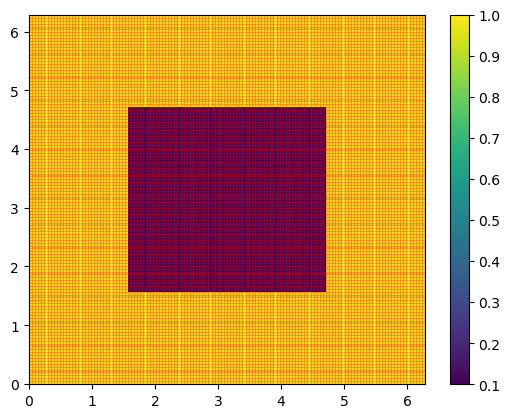

In [3]:
L = 2*np.pi
N = 512 # number of nodes in each direction including the border
x = np.linspace(0, L, N, endpoint=True)
y = np.linspace(0, L, N, endpoint=True)

XY = np.meshgrid(x, y)
grid_data = torch.tensor(np.vstack((XY[0].flatten(), XY[1].flatten())).T, dtype=torch.float, device=dev)

def a_function(x,y):
    a = np.where((x>np.pi/2)&(x<3*np.pi/2)&(y>np.pi/2)&(y<3*np.pi/2), 0.1, 1)
    return a

def A(x):
    a = torch.where((x[:,0]>torch.pi/2)&(x[:,0]<3*torch.pi/2)&(x[:,1]>torch.pi/2)&(x[:,1]<3*torch.pi/2), 0.1, 1).view(-1,1,1)
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = a * I
    return A

def A_inv(x):  
    a = torch.where((x[:,0]>torch.pi/2)&(x[:,0]<3*torch.pi/2)&(x[:,1]>torch.pi/2)&(x[:,1]<3*torch.pi/2), 0.1, 1).view(-1,1,1)
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = (1 / a) * I
    return A

eps=1
def A_interp(x): 
    x_dir = 0.5 + 0.5*torch.tanh(eps*torch.sin(x-torch.pi/2))
    a = 1 - 0.9*x_dir[:,0]*x_dir[:,1]
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = a.view(-1,1,1) * I
    return A

def A_interp_inv(x):  
    x_dir = 0.5 + 0.5*torch.tanh(eps*torch.sin(x-torch.pi/2))
    a = 1 - 0.9*x_dir[:,0]*x_dir[:,1]
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = 1/a.view(-1,1,1) * I
    return A

def H1(x):
    H = torch.zeros_like(x)
    H[:,0] = 1.
    return H

Z = a_function(XY[0].flatten(), XY[1].flatten())
plt.pcolormesh(XY[0], XY[1], Z.reshape(N, N))
plt.colorbar()
plt.scatter(data[:,0], data[:,1], s = 0.1, c='r')

# Test functions

## Spectral

In [5]:
func1 = lambda x, m, n: torch.cos(m*x[:,0]+n*x[:,1])
func2 = lambda x, m, n: torch.sin(m*x[:,0]+n*x[:,1])
N_x = 8
N_y = 8
test_functions = []

for m in range(N_x):
    for n in range(N_y):
        test_functions.append(lambda x, m=m, n=n: func1(x, m, n))
        test_functions.append(lambda x, m=m, n=n: func2(x, m, n))

test_functions = test_functions[2:]
N_test = len(test_functions)

In [6]:
# compute G if needed
for i, x in enumerate(loaders['train']):
    areas, tri = get_areas(x)
    areas = areas.to(dev)
x = x.to(dev).requires_grad_(True)

G = torch.zeros((N_test, N_test))
g_test = []
for i in range(N_test):
    y_test = test_functions[i](x)
    grad_test = torch.autograd.grad(
                outputs=y_test, inputs=x,
                grad_outputs=torch.ones_like(y_test)
            )[0]
    g_test.append(grad_test.detach())

for i in range(N_test):
    intgr = compute_int(areas, tri, g_test[i], g_test[i]).detach()
    G[i,i] = intgr

torch.save(G, "G_primal_spectral.pt")
G_inv = torch.linalg.inv(G).to(dev)

In [ ]:
fig, axs = plt.subplots(nrows=32, ncols=N_test//32, figsize=(N_test//32,32), dpi=150)
for i in range(len(test_functions)):
    axs.flat[i].pcolormesh(XY[0], XY[1], test_functions[i](grid_data).reshape(N, N).cpu().detach())
    axs.flat[i].set_axis_off()

# Primal PINN

In [7]:
net_primal = PINN(n_periodic=10, n_hidden=20, n_layers=3, period_len=L)
total_params = sum(p.numel() for p in net_primal.parameters())
print(f"Number of parameters: {total_params}")
args = {'lr' : 1e-5, 'epochs' : 40000, 'dev' : dev, 'name' : f'NN_library/VPINN/square/VSPINN_primal_{total_params}_{N_test}'}

Number of parameters: 1801


In [13]:
net_primal = load_network(net_primal, args['name']+'_39999', args)
net_primal = net_primal.to(dev)

In [8]:
losses_train, losses_val = train_primal(net_primal, loaders, args, A, H1, test_functions, G_inv, L)

Epoch: 0 mean train loss:  2.42744565e+00, mean val. loss:  7.83100665e-01
Epoch: 1 mean train loss:  2.42495227e+00, mean val. loss:  7.83009946e-01
Epoch: 2 mean train loss:  2.42246294e+00, mean val. loss:  7.82919407e-01
Epoch: 3 mean train loss:  2.41997647e+00, mean val. loss:  7.82828987e-01
Epoch: 4 mean train loss:  2.41749334e+00, mean val. loss:  7.82738626e-01
Epoch: 5 mean train loss:  2.41501427e+00, mean val. loss:  7.82648444e-01
Epoch: 6 mean train loss:  2.41253853e+00, mean val. loss:  7.82558262e-01
Epoch: 7 mean train loss:  2.41006708e+00, mean val. loss:  7.82468259e-01
Epoch: 8 mean train loss:  2.40759897e+00, mean val. loss:  7.82378376e-01
Epoch: 9 mean train loss:  2.40513468e+00, mean val. loss:  7.82288611e-01
Epoch: 10 mean train loss:  2.40267444e+00, mean val. loss:  7.82198906e-01
Epoch: 11 mean train loss:  2.40021849e+00, mean val. loss:  7.82109380e-01
Epoch: 12 mean train loss:  2.39776587e+00, mean val. loss:  7.82020032e-01
Epoch: 13 mean train l

KeyboardInterrupt: 

In [9]:
np.save(f'NN_library/training_data/square/VSPINN_primal_{total_params}_{N_test}', np.vstack([losses_train, losses_val]))

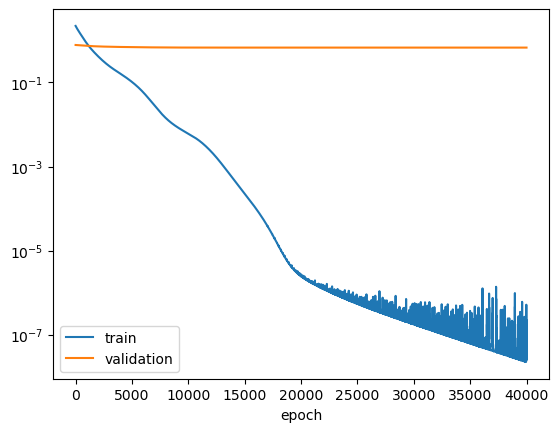

In [10]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.yscale('log')

In [11]:
U1 = net_primal(grid_data).detach().cpu()
error_1, _ = PDE_loss(grid_data, net_primal, A, H1)

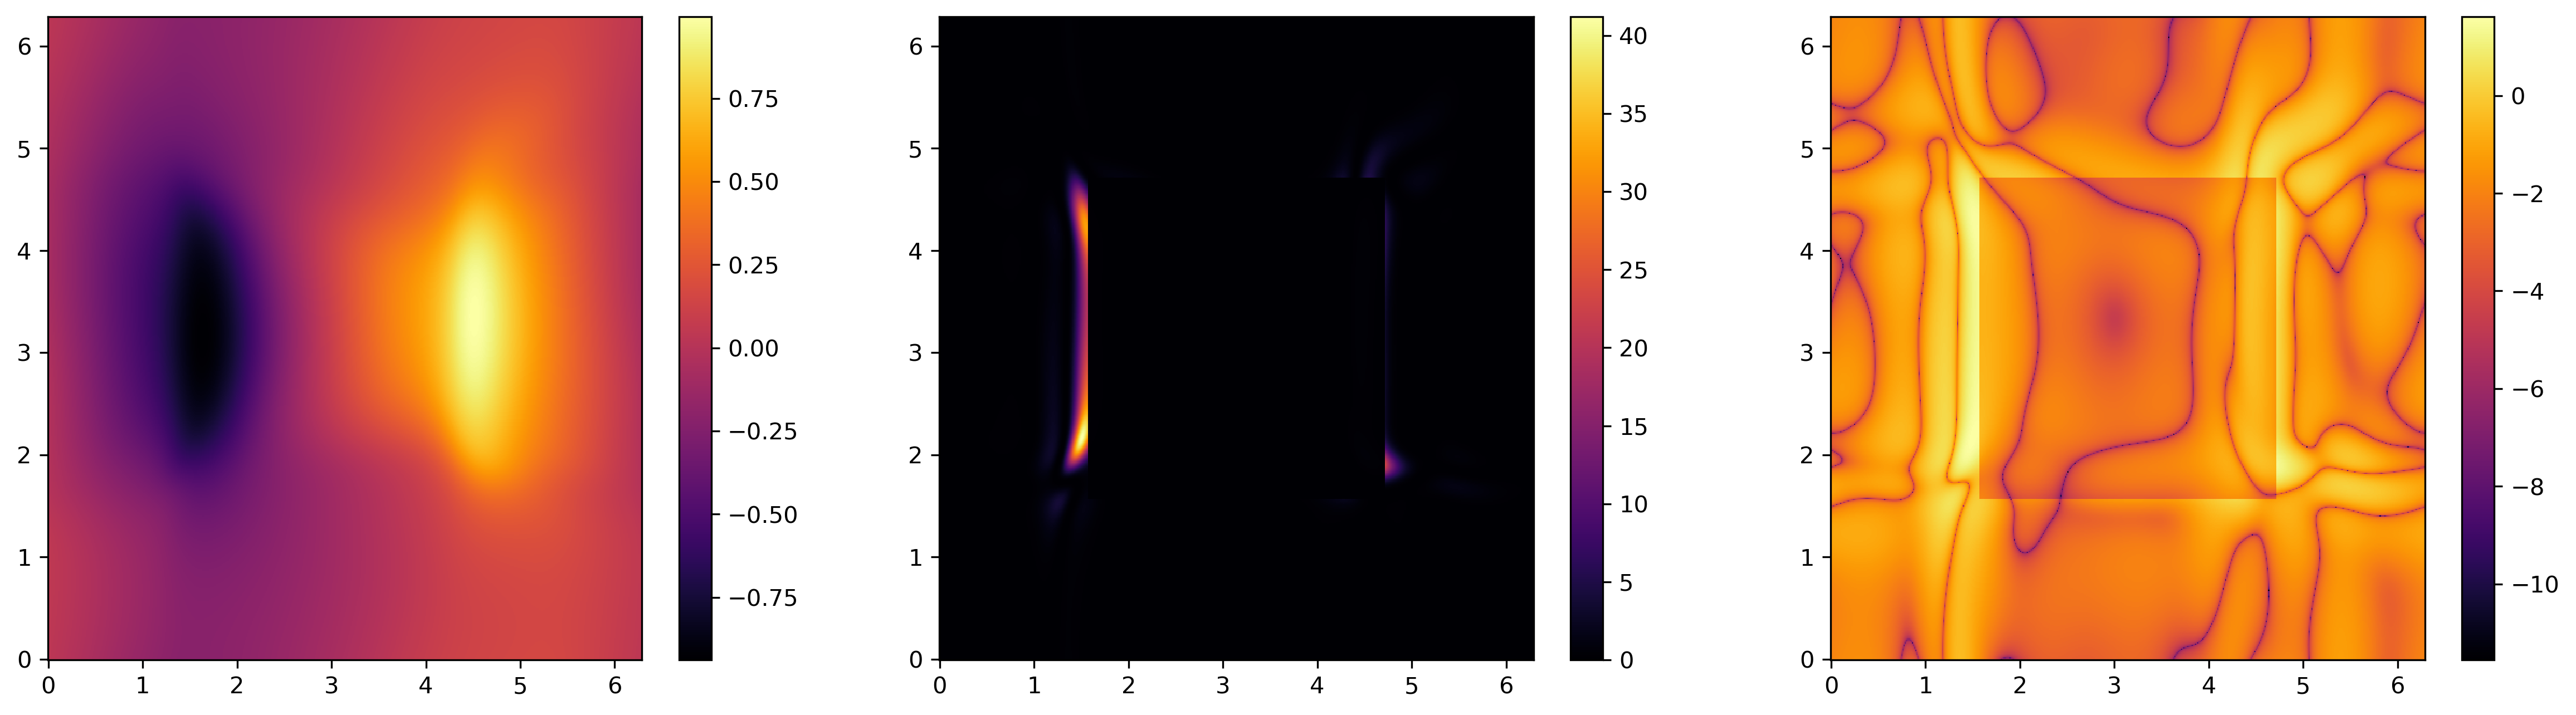

In [12]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(19.5,5), dpi=300)
pos1 = axs[0].pcolormesh(XY[0], XY[1], U1.reshape(N, N), cmap='inferno')
fig.colorbar(pos1, ax=axs[0])
pos2 = axs[1].pcolormesh(XY[0], XY[1], error_1.reshape(N, N).detach().cpu(), cmap='inferno')
fig.colorbar(pos2, ax=axs[1])
pos3 = axs[2].pcolormesh(XY[0], XY[1], np.log10(error_1.reshape(N, N).detach().cpu()), cmap='inferno')
fig.colorbar(pos3, ax=axs[2])

In [14]:
for i, x in enumerate(loaders['train']):
    areas, tri = get_areas(x)
    areas = areas.to(args['dev'])
x = x.to(args['dev'])
x_rot = torch.fliplr(x)

_, q1, gH = PDE_loss(x, net_primal, A, H1)
bound_1 = compute_estimate(areas, tri, q1, gH, L).detach()[0].item()
print(bound_1)

U1 = net_primal(x)
U2 = net_primal(x_rot)
bound_2 = compute_bound_primal(U1, U2, tri, x, A, L)[0,0]
print(bound_2)

np.save(f'bounds/square/A_u_VSPINN_{total_params}_{N_test}.npy', (bound_1, bound_2))

0.679499626159668
0.6714788724685081


# Dual PINN

In [8]:
net_dual = PINN(n_periodic=10, n_hidden=20, n_layers=3, period_len=L)
total_params = sum(p.numel() for p in net_dual.parameters())
print(f"Number of parameters: {total_params}")
args = {'lr' : 0.00001, 'epochs' : 40000, 'dev' : dev, 'name' : f'NN_library/VPINN/square/VSPINN_dual_{total_params}_{N_test}'}

Number of parameters: 1801


In [16]:
net_dual = load_network(net_dual, args['name']+'_39999', args)
net_dual = net_dual.to(dev)

In [9]:
losses_train, losses_val = train_dual(net_dual, loaders, args, A_inv, H1, test_functions, G_inv, L)

Epoch: 0 mean train loss:  2.23033188e+02, mean val. loss:  3.22756678e-01
Epoch: 1 mean train loss:  2.22963745e+02, mean val. loss:  3.22802842e-01
Epoch: 2 mean train loss:  2.22894424e+02, mean val. loss:  3.22848946e-01
Epoch: 3 mean train loss:  2.22825165e+02, mean val. loss:  3.22895020e-01
Epoch: 4 mean train loss:  2.22756012e+02, mean val. loss:  3.22941095e-01
Epoch: 5 mean train loss:  2.22686981e+02, mean val. loss:  3.22987109e-01
Epoch: 6 mean train loss:  2.22618011e+02, mean val. loss:  3.23033124e-01
Epoch: 7 mean train loss:  2.22549072e+02, mean val. loss:  3.23079109e-01
Epoch: 8 mean train loss:  2.22480286e+02, mean val. loss:  3.23125035e-01
Epoch: 9 mean train loss:  2.22411621e+02, mean val. loss:  3.23170960e-01
Epoch: 10 mean train loss:  2.22343048e+02, mean val. loss:  3.23216826e-01
Epoch: 11 mean train loss:  2.22274567e+02, mean val. loss:  3.23262662e-01
Epoch: 12 mean train loss:  2.22206161e+02, mean val. loss:  3.23308468e-01
Epoch: 13 mean train l

In [10]:
np.save(f'NN_library/training_data/square/VSPINN_dual_{total_params}_{N_test}', np.vstack([losses_train, losses_val]))

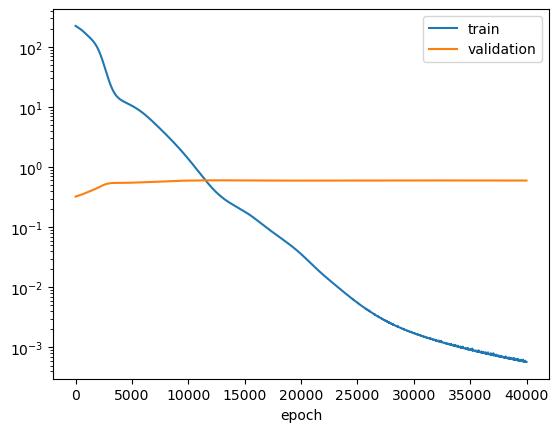

In [11]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.yscale('log')

In [25]:
U2 = net_dual(grid_data).detach().cpu()
error_2, q = PDE_loss_dual(grid_data, net_dual, A_inv, H1)

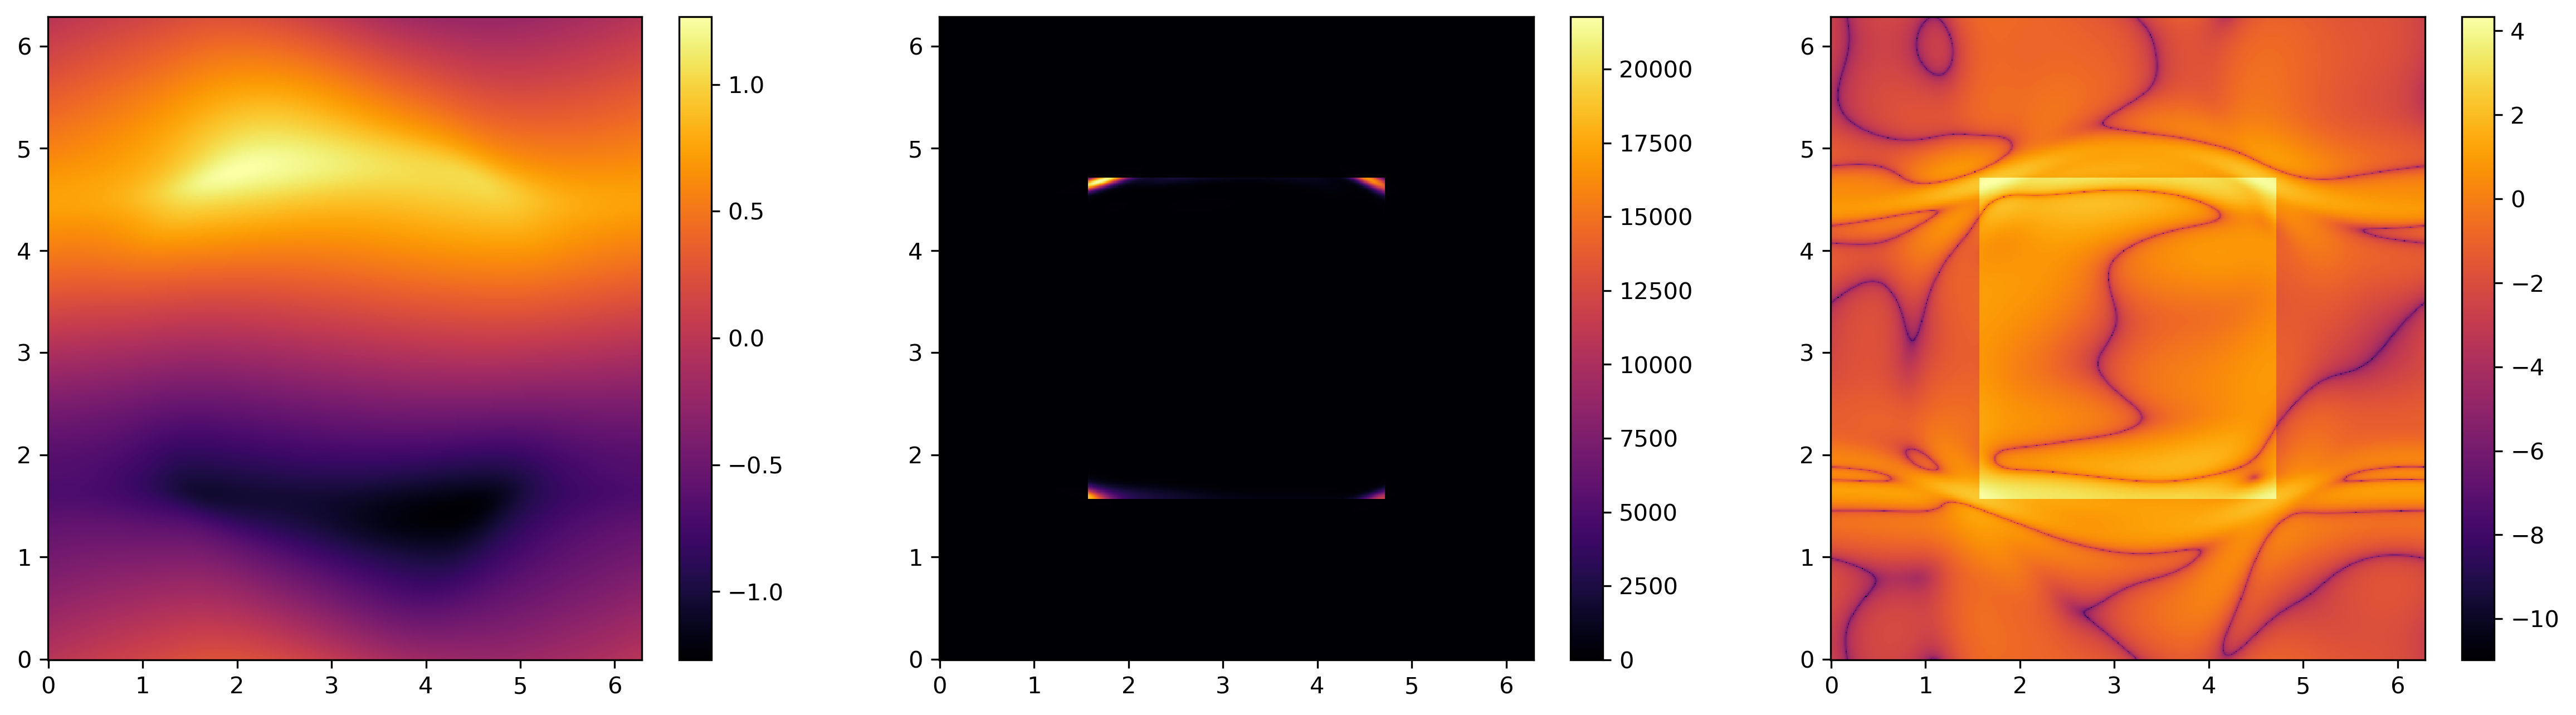

In [26]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(19.5,5), dpi=300)
pos1 = axs[0].pcolormesh(XY[0], XY[1], U2.reshape(N, N), cmap='inferno')
fig.colorbar(pos1, ax=axs[0])
pos2 = axs[1].pcolormesh(XY[0], XY[1], error_2.detach().cpu().reshape(N, N), cmap='inferno')
fig.colorbar(pos2, ax=axs[1])
pos3 = axs[2].pcolormesh(XY[0], XY[1], np.log10(error_2.detach().cpu().reshape(N, N)), cmap='inferno')
fig.colorbar(pos3, ax=axs[2])

In [13]:
for i, x in enumerate(loaders['train']):
    areas, tri = get_areas(x)
    areas = areas.to(args['dev'])
x = x.to(args['dev'])
x_rot = torch.fliplr(x)
x_rot[:,1] = -x_rot[:,1]

_, q2, gH = PDE_loss_dual(x, net_dual, A_inv, H1)
bound_1 = compute_estimate(areas, tri, q2, gH, L).detach().item()
print(1/bound_1)

W1 = net_dual(x)
W2 = net_dual(x_rot)

bound_2 = compute_bound_dual(W1, W2, tri, x, A_inv, L)[0,0]
print(bound_2)

np.save(f'bounds/square/A_l_VSPINN_{total_params}_{N_test}.npy', (1/bound_1, bound_2))

0.5977175655733366
0.5900518208273208
